*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=467

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import ModelCheckpoint
from google.colab import files, drive
from matplotlib import pyplot as plt
from music21 import *
import glob
import pickle
from IPython.display import clear_output
from IPython.display import Audio

In [ ]:
drive.mount('/content/drive') # Монтируем гугл диск

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Как устроен midi файл

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=581

In [ ]:
!unzip '/content/drive/MyDrive/Базы/Музыка midi (81)/class.zip' -d './data/'
clear_output()

unzip:  cannot find or open /content/drive/MyDrive/Базы/Музыка midi (81)/class.zip, /content/drive/MyDrive/Базы/Музыка midi (81)/class.zip.zip or /content/drive/MyDrive/Базы/Музыка midi (81)/class.zip.ZIP.


In [ ]:
midi = converter.parse('/content/data/alb_esp1.mid') # Функция парсит MIDI файл в удобный для работы формат
midi

ConverterException: ignored

In [ ]:
notes_to_parse = midi.flat.notes  # Функция, позволяющая получить список нот и аккордов в файле
for element in notes_to_parse[0:40]:
  print(element, element.offset) # Оффсет(смещение) позволяет проигрывать ноты в разное время

<music21.note.Note A> 0.5
<music21.note.Note A> 0.5
<music21.note.Note E> 1.0
<music21.note.Note E> 1.0
<music21.note.Note D> 4.25
<music21.note.Note D> 4.25
<music21.note.Note E> 13/3
<music21.note.Note E> 13/3
<music21.note.Note D> 4.5
<music21.note.Note D> 4.5
<music21.note.Note C> 5.0
<music21.note.Note C> 5.0
<music21.note.Note D> 5.5
<music21.note.Note D> 5.5
<music21.note.Note E> 6.0
<music21.note.Note E> 6.0
<music21.note.Note F> 6.5
<music21.note.Note F> 6.5
<music21.note.Note G> 7.0
<music21.note.Note G> 7.0
<music21.note.Note E> 7.5
<music21.note.Note E> 7.5
<music21.note.Note F> 8.0
<music21.note.Note F> 8.0
<music21.note.Note E> 8.5
<music21.note.Note E> 8.5
<music21.note.Note D> 8.75
<music21.note.Note E> 8.75
<music21.note.Note D> 8.75
<music21.note.Note E> 8.75
<music21.note.Note D> 9.0
<music21.note.Note D> 9.0
<music21.note.Note C> 10.0
<music21.note.Note C> 10.0
<music21.note.Note B-> 11.0
<music21.note.Note B-> 11.0
<music21.note.Note A> 12.0
<music21.note.Note A> 1

In [ ]:
s2 = instrument.partitionByInstrument(midi) # Если в файле есть несколько инструментов
s2.parts[0] # Берем только часть с пианино

<music21.stream.Part Piano>

## Собираем список нот

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=858

In [ ]:
notes = [] # Здесь будут храниться все ноты из всех файлов
for i, file in enumerate(glob.glob("/content/data/*.mid")):
  midi = converter.parse(file) 
  print('\r', 'Обрабатывается файл', i, " ",file, end='')
  notes_to_parse = None
  try: # Если в файле нет разных иструментов 
    notes_to_parse = midi.flat.notes
  except: # Если есть разные инструменты
    s2 = instrument.partitionByInstrument(midi)
    notes_to_parse = s2.parts[0].recurse() # Итератор


  for element in notes_to_parse: # Добавляем в список ноту или аккорд
    if isinstance(element, note.Note): # Если нота, просто добавляем ее
      notes.append(str(element.pitch)) 
    elif isinstance(element, chord.Chord): # Если аккорд, то записываем числовой вариант всех нот через точку
      notes.append('.'.join(str(n) for n in element.normalOrder))

 Обрабатывается файл 80   /content/data/chpn-p21.mid

In [ ]:
notes_ = []
midi = converter.parse('/content/data/alb_esp1.mid') 
s2 = instrument.partitionByInstrument(midi)
notes_to_parse = s2.parts[0].recurse() # Итератор
for element in notes_to_parse: # Добавляем в список ноту или аккорд
    # if isinstance(element, note.Note): # Если нота, просто добавляем ее
    #     notes_.append(str(element.pitch)) 
    if isinstance(element, chord.Chord): # Если аккорд, то записываем числовой вариант всех нот через точку
        notes_.append('.'.join(str(n) for n in element.normalOrder))

In [ ]:
notes_[:10]

['1.4', '10.2.4', '1.4', '10.2.4', '4.10', '2.8', '4.9', '9.1.4']

## Сохраняем полученный список на диск и загружаем

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=1200




Сохранение

In [ ]:
with open('notes', 'wb') as filepath:
  pickle.dump(notes, filepath)

Загрузка

In [ ]:
with open ('/content/drive/MyDrive/Предобученные сети/Генерация музыки/notes', 'rb') as file:
  notes = pickle.load(file)

# Подготовка данных

In [ ]:
notes[510:520]

['G4', '1.4', 'F4', 'G4', 'F4', 'G4', '2.5', 'F4', 'C5', 'B-2']

In [ ]:
len(notes)

139269

In [ ]:
n_list = set(notes) # Уникальные ноты и аккорды
len(n_list) # Их количество

351

In [ ]:
sequence_length = 100 # длина последовательности нот/аккордов, по которой сеть будет делать предсказания

# Получаем отсортированный список всех уникальных нот и аккордов
pitchnames = sorted(n_list)

# Создаем словарь, сопоставляющий ноту/аккорд числу(int)
note_to_int = dict((note, number) for number, note in enumerate(pitchnames)) 

network_input = [] # Список со всеми последовательностями
network_output = [] # Список со всеми элементами, идущими после последовательности

# Создаем обучающую выборку
for i in range(0, len(notes) - sequence_length, 1):
  sequence_in = notes[i:i + sequence_length] # Выбираем последовательность длины sequence_length
  sequence_out = notes[i + sequence_length]  # Следующий за последовательностью элемент
  network_input.append([note_to_int[char] for char in sequence_in]) # Добавляем в список последовательность, предварительно переведя все ноты/аккорды в числа
  network_output.append(note_to_int[sequence_out]) # Добавляем в список следующий за последовательностью элемент, переведя его в число

n_patterns = len(network_input) # Количество полученных последовательностей

# Делаем решейп, чтобы сеть могла обучаться
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# Нормализируем входные данные
network_input = network_input / float(len(n_list))
# Выходые данные преобразуем в one-hot encoding
network_output = np.array(network_output)
# network_output = keras.utils.to_categorical(network_output)

In [ ]:
network_input.shape

(139169, 100, 1)

# Архитектура сети

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=1557

In [ ]:
def create_network(network_input, n_list, dropout=0.3):

    model = Sequential()
    model.add(LSTM(
                        256,
                        input_shape=(network_input.shape[1], network_input.shape[2]),
                        return_sequences=True 
                        ))
    model.add(Dropout(dropout))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(256))
    model.add(Dense(128))
    model.add(Dropout(dropout))
    model.add(Dense(len(n_list)))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

In [ ]:
model = create_network(network_input, n_list)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 256)          525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

Для обучения сети использовался ModelCheckpoint, позволяющий сохранять веса в процессе обучения

In [ ]:
filepath = "/content/drive/MyDrive/Предобученные сети/Генерация музыки/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"    # Где и с каким именем сохраняются веса
checkpoint = ModelCheckpoint(filepath,
                            monitor='loss',
                            verbose=0,
                            save_weights_only = True, # Сохраняем только веса   
                            save_best_only=True,      # Сохраняем только при уменьшении ошибки
                            mode='min',
                            )    
callbacks_list = [checkpoint]   

model.fit(network_input, network_output, epochs=200, 
          batch_size=128, callbacks=callbacks_list)

Epoch 1/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.6147 - accuracy: 0.0282
Epoch 2/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.5472 - accuracy: 0.0295
Epoch 3/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.5078 - accuracy: 0.0329
Epoch 4/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.4831 - accuracy: 0.0365
Epoch 5/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.4573 - accuracy: 0.0392
Epoch 6/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.4193 - accuracy: 0.0459
Epoch 7/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.3667 - accuracy: 0.0534
Epoch 8/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.2919 - accuracy: 0.0631
Epoch 9/200
1088/1088 [==============================] - 36s 33ms/step - loss: 4.2012 - accuracy: 0.0766
Epoch 10/200
1088/1088 [==============================]

In [ ]:
weights = "/content/drive/MyDrive/Предобученные сети/Генерация музыки/weights-improvement-200-1.6791.hdf5" # Загружаем натренированные веса, так как сеть довольно долго обучается
if(len(weights)>0): model.load_weights(weights)

In [ ]:
filepath = "/content/drive/MyDrive/Предобученные сети/Генерация музыки/weights-improvement_1-{epoch:02d}-{loss:.4f}.hdf5"    # Где и с каким именем сохраняются веса
checkpoint = ModelCheckpoint(filepath,
                            monitor='loss',
                            verbose=0,
                            save_weights_only = True, # Сохраняем только веса   
                            save_best_only=True,      # Сохраняем только при уменьшении ошибки
                            mode='min',
                            )    
callbacks_list = [checkpoint]   

model.fit(network_input, network_output, epochs=200, 
          batch_size=128, callbacks=callbacks_list)

Epoch 1/200
1088/1088 [==============================] - 44s 33ms/step - loss: 1.6969 - accuracy: 0.5590
Epoch 2/200
1088/1088 [==============================] - 36s 33ms/step - loss: 1.6501 - accuracy: 0.5690
Epoch 3/200
1088/1088 [==============================] - 36s 33ms/step - loss: 1.6463 - accuracy: 0.5693
Epoch 4/200
1088/1088 [==============================] - 36s 33ms/step - loss: 1.6465 - accuracy: 0.5711
Epoch 5/200
1088/1088 [==============================] - 37s 34ms/step - loss: 1.6342 - accuracy: 0.5735
Epoch 6/200
1088/1088 [==============================] - 36s 33ms/step - loss: 1.6453 - accuracy: 0.5722
Epoch 7/200
1088/1088 [==============================] - 36s 33ms/step - loss: 1.6440 - accuracy: 0.5736
Epoch 8/200
1088/1088 [==============================] - 36s 33ms/step - loss: 1.6491 - accuracy: 0.5732
Epoch 9/200
1088/1088 [==============================] - 36s 33ms/step - loss: 1.6410 - accuracy: 0.5706
Epoch 10/200
1088/1088 [==============================]

In [ ]:
weights = "/content/drive/MyDrive/Предобученные сети/Генерация музыки/weights-improvement_1-198-1.3536.hdf5" # Загружаем натренированные веса, так как сеть довольно долго обучается
if(len(weights)>0): model.load_weights(weights)

In [ ]:
model.fit(network_input, network_output, epochs=1, 
          batch_size=128)

1088/1088 [==============================] - 39s 33ms/step - loss: 1.3748 - accuracy: 0.6391


## Генерация музыки

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=1637

Для генерации музыки будем использовать следующий подход:

1. Выбираем случайную последовательность из обучающей выборки (далее паттерн)
2. Передаем паттерн модели для генерации нового элемента
3. Добавляем полученный элемент в финальный список и в конец паттерна
4. Удаляем первый элемент в паттерне
5. Возвращаемся к шагу 2

In [ ]:
# Выбираем случайную последовательность
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames)) # Словарь для перевода чисел в ноты/аккорды
pattern = list(network_input[start])
prediction_output = [] # Список, в котором будет храниться сгенерированная последовательность элементов

# Генерируем 500 нот/аккордов (около 2 минут композиция)
for i,note_index in enumerate(range(500)):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1)) # Решейп паттерна для сети
    prediction_input = prediction_input / float(len(n_list)) # Нормализация
    prediction = model.predict(prediction_input.astype('float32'), verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index] # Полученный результат
    print('\r', 'Предсказано ', i, " ",result, end='')
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

 Предсказано  5   3

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 Предсказано  499   10.1

В нашей сети мы не учитывали оффсет(смещение), поэтому после каждой ноты будем просто увеличивать его на 0.5

In [ ]:
offset = 0
output_notes = [] # список нот и аккордов

# Создаем список нот/аккордов из полученных от сети элементов
for pattern in prediction_output:
    # Если элемент - аккорд
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.') # Получаем список всех нот в аккорде
        notes = [] # Здесь будут храниться все ноты в аккорде
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note)) # Создаем объект ноты
            new_note.storedInstrument = instrument.Piano()  # Указываем инструмент, который должен сыграть ноту
            notes.append(new_note) # Добавляем полученную ноту в список
        new_chord = chord.Chord(notes) # Создаем объект аккорда
        new_chord.offset = offset # Добавляем смещение
        output_notes.append(new_chord) # Добавляем полученный аккорд в output_notes
    # Если элемент - нота
    else:
        new_note = note.Note(pattern) # Создаем объект ноты
        new_note.offset = offset # Добавляем смещение
        new_note.storedInstrument = instrument.Piano() # Указываем инструмент, который должен сыграть ноту
        output_notes.append(new_note) # Добавляем полученную ноту в output_notes

    # Увеличиваем смещение чтобы ноты не наслаивались
    offset += 0.5

midi_stream = stream.Stream(output_notes) # Создаем stream объект из списка нот/аккордов

## Графики

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=1975

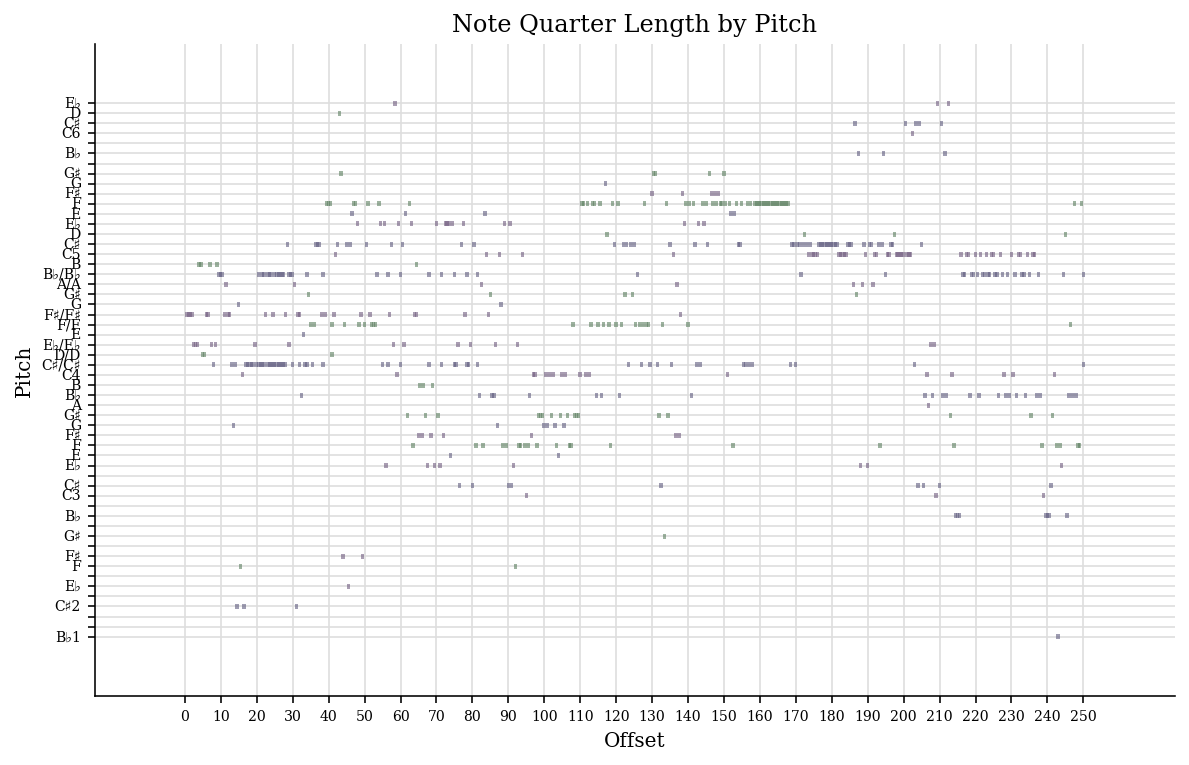

In [ ]:
midi_stream.plot() # Вся композиция

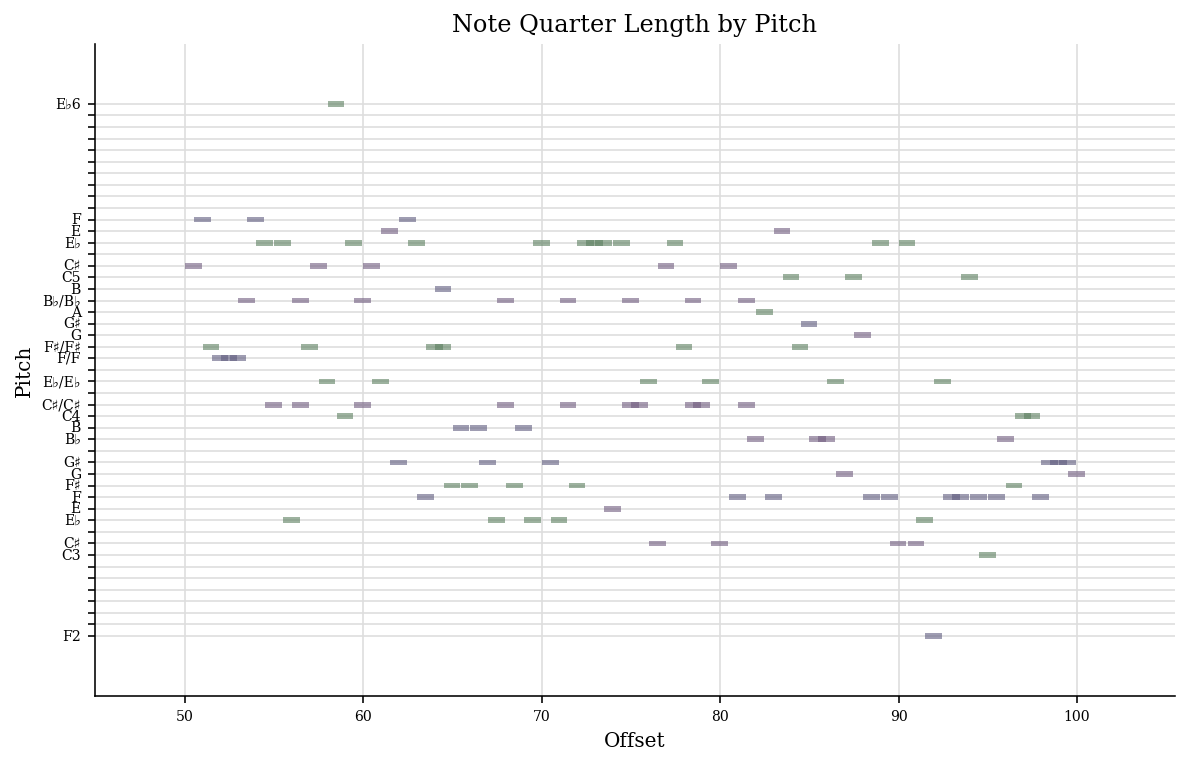

In [ ]:
midi_stream[100:200].plot() # Часть композиции

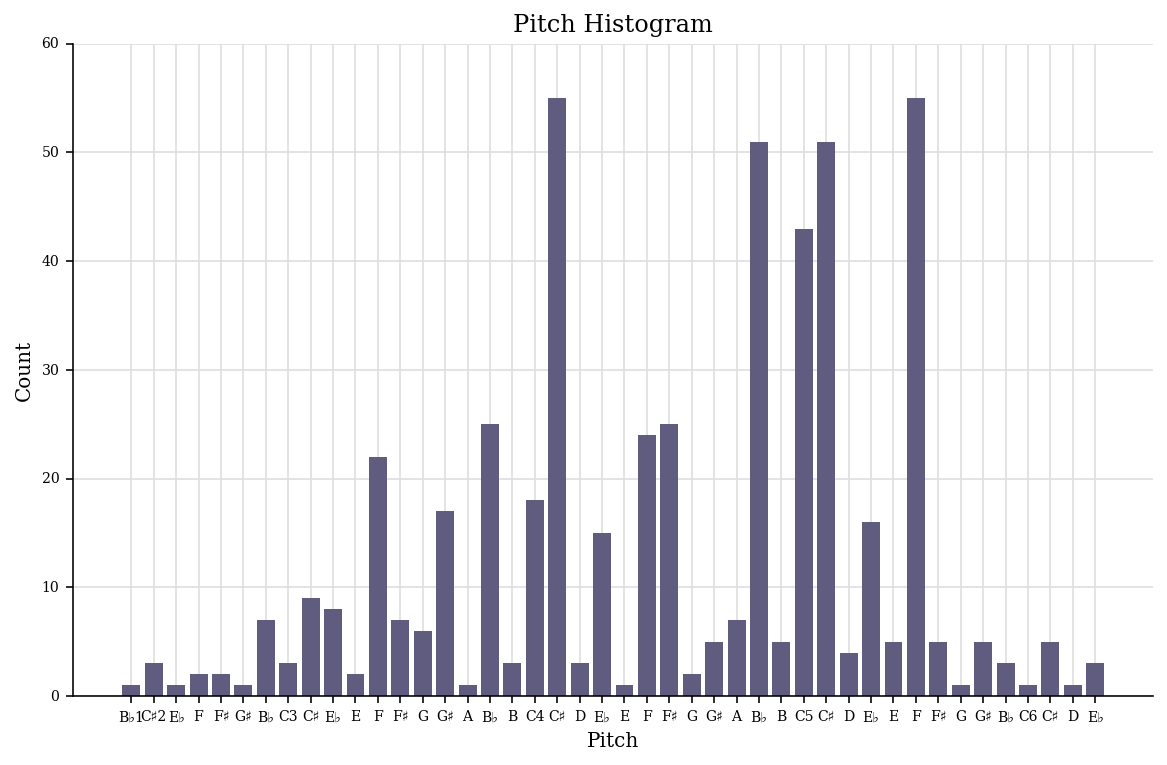

In [ ]:
midi_stream.plot('histogram', 'pitch') # Гистограмма с количеством нот

## Прослушиваем

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=2007

In [ ]:
!apt install fluidsynth 
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
clear_output()

In [ ]:
midi_stream.write('midi', fp='test_output.mid') # Сохраняем midi файл на диск 
!fluidsynth -ni font.sf2 '/content/test_output.mid' -F 'output.wav' -r 44100 # Перекодируем в wav c частотой дискретизации 44100
Audio('output.wav')

## Cкачиваем файл

Midi

In [ ]:
files.download('test_output.mid')

Wav

In [ ]:
files.download('output.wav')

# Библиотека от Google - Magenta


## Готовим последовательность на вход

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=2165

In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library
!pip install -qU magenta
import magenta
import note_seq
import tensorflow
from note_seq.protobuf import music_pb2
from magenta.models.melody_rnn import melody_rnn_sequence_generator
from magenta.models.shared import sequence_generator_bundle
from note_seq.protobuf import generator_pb2
clear_output()

In [ ]:
# Создаем свою последовательность с помощью note_seq

teapot = music_pb2.NoteSequence()
teapot.notes.add(pitch=69, start_time=0, end_time=0.5, velocity=80)
teapot.notes.add(pitch=71, start_time=0.5, end_time=1, velocity=80)
teapot.notes.add(pitch=73, start_time=1, end_time=1.5, velocity=80)
teapot.notes.add(pitch=74, start_time=1.5, end_time=2, velocity=80)
teapot.notes.add(pitch=76, start_time=2, end_time=2.5, velocity=80)
teapot.notes.add(pitch=81, start_time=3, end_time=4, velocity=80)
teapot.notes.add(pitch=78, start_time=4, end_time=5, velocity=80)
teapot.notes.add(pitch=81, start_time=5, end_time=6, velocity=80)
teapot.notes.add(pitch=76, start_time=6, end_time=8, velocity=80)
teapot.total_time = 8

teapot.tempos.add(qpm=60);

note_seq.plot_sequence(teapot)
note_seq.play_sequence(teapot,synth=note_seq.synthesize)

In [ ]:
# Меняя pitch разные звуки

drums = music_pb2.NoteSequence()
drums.notes.add(pitch=36, start_time=0, end_time=0.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=38, start_time=0, end_time=0.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0, end_time=0.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=46, start_time=0, end_time=0.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0.25, end_time=0.375, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0.375, end_time=0.5, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0.5, end_time=0.625, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=50, start_time=0.5, end_time=0.625, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=36, start_time=0.75, end_time=0.875, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=38, start_time=0.75, end_time=0.875, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0.75, end_time=0.875, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=45, start_time=0.75, end_time=0.875, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=36, start_time=1, end_time=1.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=1, end_time=1.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=46, start_time=1, end_time=1.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=1.25, end_time=1.375, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=48, start_time=1.25, end_time=1.375, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=50, start_time=1.25, end_time=1.375, is_drum=True, instrument=10, velocity=80)
drums.total_time = 1.375

drums.tempos.add(qpm=60)

# Визуализация результата
note_seq.plot_sequence(drums)
note_seq.play_sequence(drums,synth=note_seq.fluidsynth)

In [ ]:
# Создаем midi файл с именем sample_output.mid, содержащий звуки teapot
note_seq.sequence_proto_to_midi_file(teapot, 'sample_output.mid')

## Модель

*Разбор данного раздела:* https://youtu.be/VS6DHal1xYw?t=2378

Magenta это целый набор разных предобученных моделей ([**список**](https://github.com/magenta/magenta/tree/master/magenta/models)) 

--------------
Некотрые из них:

- [**MelodyRNN**](https://github.com/magenta/magenta/tree/master/magenta/models/melody_rnn) - Мы подаем последовательность и она продолжает генерить в ее стиле.

- [**MusicVAE**](https://github.com/magenta/magenta/tree/master/magenta/models/music_vae) - Генерирует новые последовательности нот или интерполирует их между двумя последовательностями.


In [ ]:
# =========
# MelodyRNN
# =========
# https://arxiv.org/pdf/1712.05274.pdf


# Загружаем basic_rnn.mag. Так же можно загружать любые другие модели от Magenta

note_seq.notebook_utils.download_bundle('basic_rnn.mag', '/content/')

bundle = sequence_generator_bundle.read_bundle_file('/content/basic_rnn.mag')
generator_map = melody_rnn_sequence_generator.get_generator_map()
melody_rnn = generator_map['basic_rnn'](checkpoint=None, bundle=bundle)
melody_rnn.initialize()

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmprevywjlw/model.ckpt


In [ ]:
# Можем настроить количество шагов в новой последовательности
# Также «температуру» результата - чем выше температура, тем более случайной (и менее похожей на ввод) будет наша последовательность.


input_sequence = teapot # Последовательность
num_steps = 128 # Длина новой последовательности
temperature = 1.0 # Температура


last_end_time = (max(n.end_time for n in input_sequence.notes)
                  if input_sequence.notes else 0)
qpm = input_sequence.tempos[0].qpm 
seconds_per_step = 60.0 / qpm / melody_rnn.steps_per_quarter
total_seconds = num_steps * seconds_per_step

generator_options = generator_pb2.GeneratorOptions()
generator_options.args['temperature'].float_value = temperature
generate_section = generator_options.generate_sections.add(
    start_time=last_end_time + seconds_per_step,
    end_time=total_seconds)

# Сгенерируем последовательность по параметрам которые объявили выше.
sequence = melody_rnn.generate(input_sequence, generator_options)

note_seq.plot_sequence(sequence)
note_seq.play_sequence(sequence, synth=note_seq.fluidsynth)

INFO:tensorflow:Beam search yields sequence with log-likelihood: -115.746330 


In [ ]:
# =========
# MusicVAE
# =========
# https://arxiv.org/pdf/1803.05428.pdf


# Загружаем один из вариантов предобученого VAE

!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/music_vae/colab2/checkpoints/mel_2bar_big.ckpt.* /content/
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel

# Создаем модель

music_vae = TrainedModel(
      configs.CONFIG_MAP['cat-mel_2bar_big'], 
      batch_size=4, 
      checkpoint_dir_or_path='/content/mel_2bar_big.ckpt')
clear_output()

In [ ]:
# Можем менять сколько новых последовательностей нужно сгенерировать
# Количество шагов в новой последовательности
# Также «температуру» результата - чем выше температура, тем более случайный (и менее похожий на ввод ) ваша последовательность будет


generated_sequences = music_vae.sample(n=3, length=80, temperature=0.1)

for ns in generated_sequences:
  note_seq.plot_sequence(ns)
  note_seq.play_sequence(ns, synth=note_seq.fluidsynth)

In [ ]:
# https://salu133445.github.io/muspy/doc/metrics.html

# https://github.com/magenta/magenta/tree/master/magenta/models

# https://magenta.tensorflow.org/gansynth